In [ ]:
!pip install np_utils

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization, ReLU, Activation
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten, UpSampling2D, ZeroPadding2D
from keras.constraints import Constraint
from tensorflow.keras.optimizers import Adam, RMSprop
from keras import initializers
from keras.utils import np_utils
from tensorflow.keras.utils import plot_model
from keras import backend as K
import tensorflow as tf
from keras.layers import Dropout
from keras.datasets import cifar10
from keras import layers

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()


170508288/170498071 [==============================] - 4s 0us/step


In [3]:
X_train = np.float32(X_train)
X_train = (X_train - 127.5) / 127.5

In [4]:
class ClipConstraint(Constraint):
	def __init__(self, clip_value):
		self.clip_value = clip_value
 
	def __call__(self, weights):
		return backend.clip(weights, -self.clip_value, self.clip_value)
 
	def get_config(self):
		return {'clip_value': self.clip_value}

In [30]:
# init = initializers.RandomNormal(stddev=0.02)

const = ClipConstraint(0.01)

# Generator network
generator = Sequential()
# # foundation for 4x4 image
# n_nodes = 256 * 4 * 4
# generator.add(Dense(n_nodes, input_dim=100))
# generator.add(LeakyReLU(alpha=0.2))
# generator.add(Reshape((4, 4, 256)))
# # upsample to 8x8
# generator.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_constraint=const))
# generator.add(LeakyReLU(alpha=0.2))
# # upsample to 16x16
# generator.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_constraint=const))
# generator.add(LeakyReLU(alpha=0.2))
# # upsample to 32x32
# generator.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_constraint=const))
# generator.add(LeakyReLU(alpha=0.2))
# # output layer
# generator.add(Conv2D(3, (3,3), activation='tanh', padding='same'))

class Space():

    def __init__(self, shape=None):
        self.shape = shape

    def sampling(self):
        raise NotImplemented


class Euclidean(Space):

    def __init__(self, shape):
        super().__init__(shape=shape)

    def sampling(self, batch_size=None):
        """
        >>> R = Euclidean(1)
        >>> R.sampling().shape
        (1,)
        >>> R.sampling(10).shape
        (10, 1)
        """
        if batch_size is None:
            size = self.shape
        elif type(self.shape) == int:
            size = (batch_size, self.shape)
        else:
            size = (batch_size,) + tuple(self.shape)
        return np.random.normal(size=size)


X = Space(shape=(32, 32, 3))
Z = Euclidean(shape=(100,))

generator.add(layers.Dense(128 * 4 * 4, activation='relu', input_shape=Z.shape))
generator.add(layers.Reshape((4, 4, 128)))
generator.add(layers.UpSampling2D())
generator.add(layers.Conv2D(128, kernel_size=4, padding='same'))
generator.add(layers.BatchNormalization(momentum=0.8))
generator.add(layers.Activation('relu'))
generator.add(layers.UpSampling2D())
generator.add(layers.Conv2D(64, kernel_size=4, padding='same'))
generator.add(layers.BatchNormalization(momentum=0.8))
generator.add(layers.Activation('relu'))
generator.add(layers.UpSampling2D())
generator.add(layers.Conv2D(X.shape[2], kernel_size=4, padding='same', activation='tanh'))


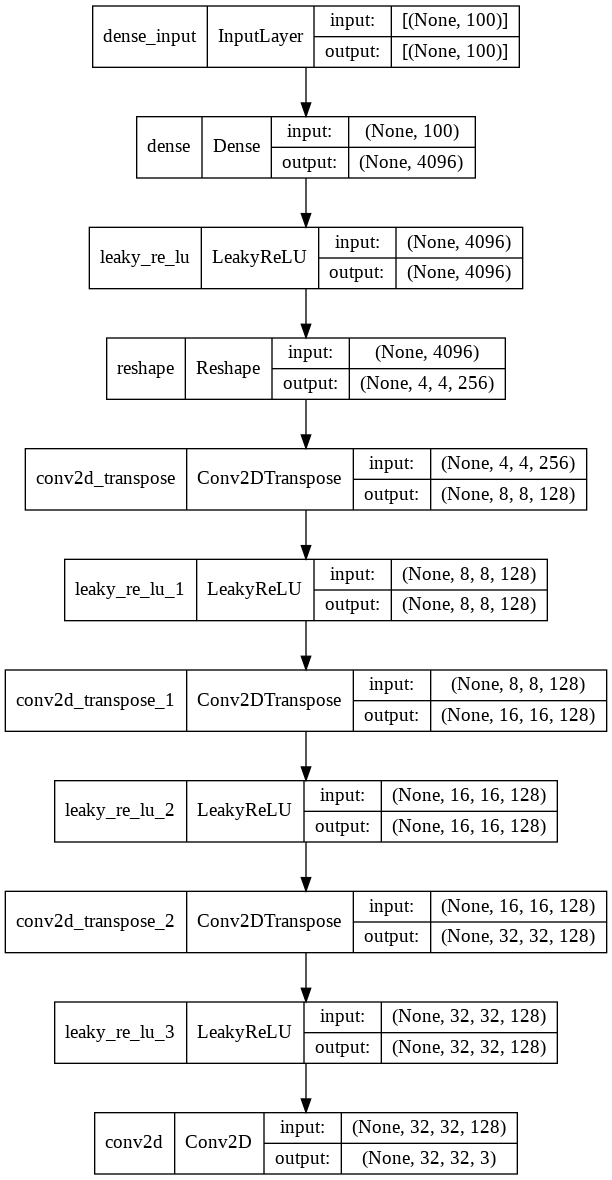

In [ ]:
plot_model(generator, show_shapes=True)

In [6]:
from keras import backend
 
def wasserstein_loss(y_true, y_pred):
	return backend.mean(y_true * y_pred)

In [36]:
# Discriminator network
discriminator = Sequential()
	# normal
# discriminator.add(Conv2D(64, (3,3), padding='same', input_shape=X_train[0].shape))
# discriminator.add(LeakyReLU(alpha=0.2))
# # downsample
# discriminator.add(Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_constraint=const))
# discriminator.add(LeakyReLU(alpha=0.2))
# # downsample
# discriminator.add(Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_constraint=const))
# discriminator.add(LeakyReLU(alpha=0.2))
# # downsample
# discriminator.add(Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_constraint=const))
# discriminator.add(LeakyReLU(alpha=0.2))
# # classifier
# discriminator.add(Flatten())
# discriminator.add(Dropout(0.4))
# # discriminator.add(Dense(1, activation='sigmoid'))
# discriminator.add(Dense(1, activation='linear'))
# # compile model

discriminator.add(layers.Conv2D(16, kernel_size=2, padding='same', activation='relu',
                  input_shape=X_train[0].shape))
discriminator.add(layers.Dropout(0.25))
discriminator.add(layers.Conv2D(32, kernel_size=3, strides=2, padding='same'))
discriminator.add(layers.BatchNormalization())
discriminator.add(layers.Activation('relu'))
discriminator.add(layers.Dropout(0.25))
discriminator.add(layers.Conv2D(64, kernel_size=3, strides=2, padding='same'))
discriminator.add(layers.BatchNormalization())
discriminator.add(layers.Activation('relu'))
discriminator.add(layers.Dropout(0.25))
discriminator.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same'))
discriminator.add(layers.BatchNormalization())
discriminator.add(layers.Activation('relu'))
discriminator.add(layers.Dropout(0.25))
discriminator.add(layers.Flatten())
discriminator.add(layers.Dense(1))
# opt = Adam(lr=0.0002, beta_1=0.5)
opt = RMSprop(lr=0.00005)
discriminator.compile(loss=wasserstein_loss, optimizer=opt, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


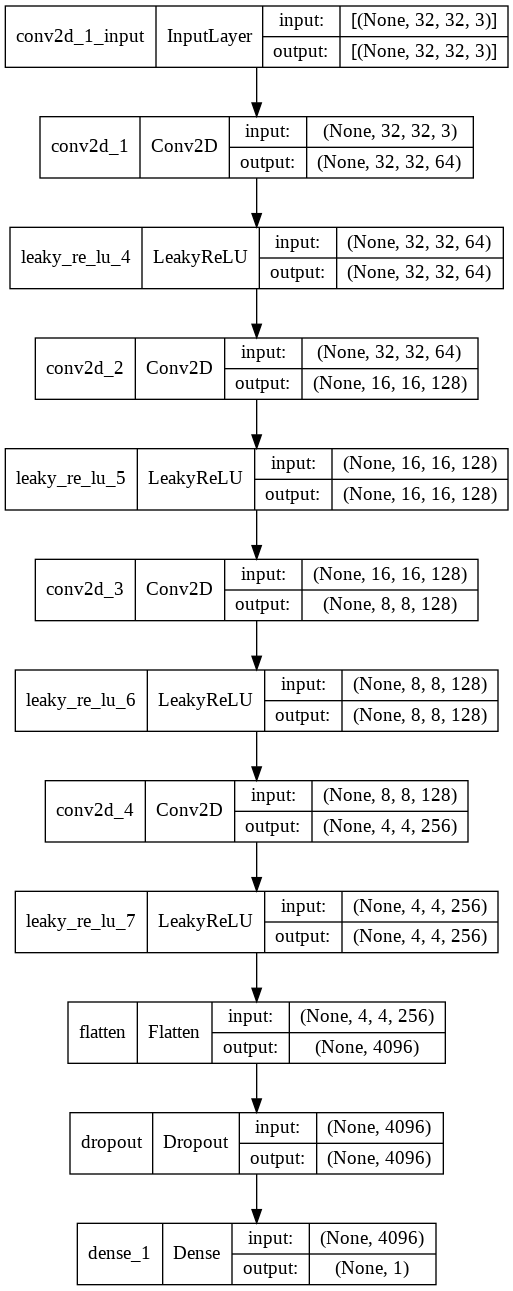

In [ ]:
plot_model(discriminator, show_shapes=True)

In [37]:
discriminator.trainable = False
z = Input(shape=(100,))
img = generator(z)
decision = discriminator(img)
GAN = Model(inputs=z, outputs=decision)
opt = RMSprop(lr=0.00005)

GAN.compile(opt, loss=wasserstein_loss, metrics=['binary_accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


epoch = 1/22


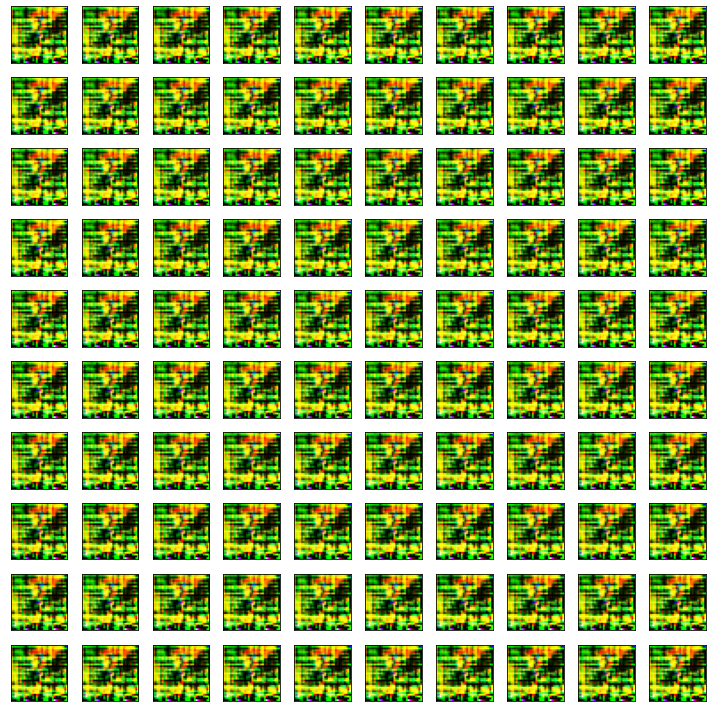

epoch = 2/22
epoch = 3/22


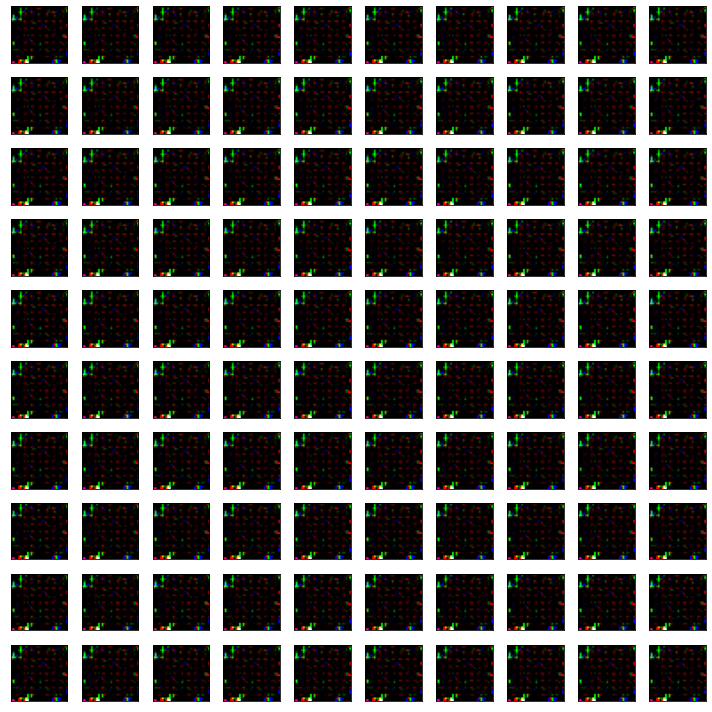

epoch = 4/22
epoch = 5/22


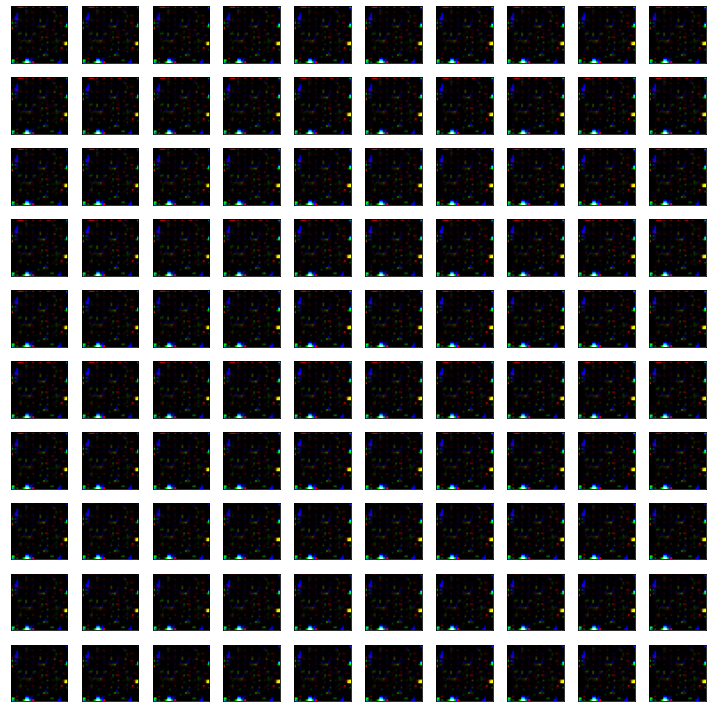

KeyboardInterrupt: ignored

In [38]:
epochs = 22
batch_size = 32

def noisy_labels(y, p_flip):
	n_select = int(p_flip * y.shape[0])
	flip_ix = np.random.choice([i for i in range(y.shape[0])], size=n_select)
	y[flip_ix] = 1 - y[flip_ix]
	return y

y_real = -np.ones(shape=(batch_size, 1))
y_fake = np.ones(shape=(batch_size, 1))

d_loss = []
g_loss = []

for e in range(epochs):
    for i in range(len(X_train) // batch_size):
        # discriminator learn real
        for _ in range(2):
          discriminator.trainable = True
          X_batch = X_train[i*batch_size:(i+1)*batch_size]
          # d_loss_real = discriminator.train_on_batch(x=X_batch,y=y_real*0.9)
          d_loss_real = discriminator.train_on_batch(x=X_batch,y=y_real)

          z = np.random.normal(loc=0, scale=1, size=(batch_size, 100))
          #generator generates fake
          X_fake = generator.predict_on_batch(z)
          #discriminator learn fake
          d_loss_fake = discriminator.train_on_batch(x=X_fake, y=y_fake)
          for layer in discriminator.layers:
              ws = layer.get_weights()
              layer.set_weights([np.clip(w, -0.1, 0.1) for w in ws])

        #mean of fake and real loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        discriminator.trainable = False
        #train generator
        g_loss_batch = GAN.train_on_batch(x=z, y=y_real)

    d_loss.append(d_loss_batch)
    g_loss.append(g_loss_batch[0])
    print('epoch = %d/%d' % (e + 1, epochs))

    #plot 10x10 pictures 
    if e % 2 == 0:
        samples = 100
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, 100)))
        
        fig = plt.figure(figsize=(10,10))
        for k in range(samples):
            plt.subplot(10,10, k + 1, xticks=[], yticks=[])
            plt.imshow((x_fake[k] + 1)/2)
            plt.tight_layout()
        plt.show()

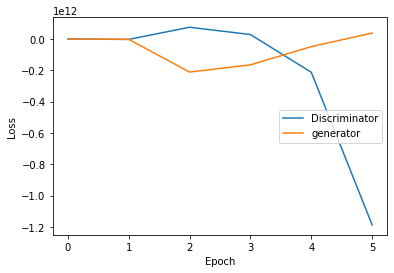

In [15]:
plt.plot(d_loss)
plt.plot(g_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'generator'], loc='center right')
plt.show()